<a href="https://colab.research.google.com/github/gcarrillo12/mmci_applied_ds/blob/master/Copy_of_ce4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational Exercise 4: Exploring Overfitting

---
In this assignment, we'll continue to develop models that predict malignancy in the [Wisconsin Breast Cancer Diagnosis Dataset][1], but this time we'll be exploring overfitting and taking a first look at some techniques for mitigating it.

Goals are as follows:

- Continue to gain experience training and evaluate logistic regression and multilayer perceptron models in `sklearn`
- Critically interpret and contextualize model performance
- Observe overfitting and understand its practical relevance
- See how early stopping and regularization can be used to mitigate overfitting

We'll be using the same libraries as before:

- `numpy` for efficient math operations
- `pandas` for dataframes and dataframe operations
- `matplotlib` for visualization/plotting
- `sklearn` gives us a convenient way to load our dataset, train our models, and evaluate their performance. Very soon, however, we'll start to work with `tensorflow`, which is much more customizable.

[1]: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

## Loading the data

Once again we'll use `sklearn` to load the dataset without having to find and download a `.csv` file on our own.

**Important**: if you encounter an error with `load_breast_cancer`, try upgrading `sklearn` by adding a code block with the following:
> `!pip install --upgrade scikit-learn`

We'll also flip some labels to make the problem a bit more difficult just like in the previous exercise. Please refer to earlier assignments if you are not sure about the details here.

Additionally -- and this is new -- we're going to *add 100 new predictors*, all of which are just random noise. In other words, we're making the problem even more difficult by adding predictors that are not informative with respect to the outcome. Our models now face the more difficult task of picking out the informative features from the noise. This is done in the last two lines of the block.

In [ ]:
from sklearn.datasets import load_breast_cancer
df_true, y_true = load_breast_cancer(return_X_y=True, as_frame=True)
y_true = 1 - y_true # let's set benign to 0 and malignant to 1 to stick to convention

def flip_some_labels(labels, flip_rate=.1, random_seed=0):
    return (labels + (np.random.RandomState(random_seed).rand(len(labels)) < flip_rate)) % 2

y = flip_some_labels(y_true)

noisy_features = pd.DataFrame(np.random.RandomState(2022).randn(len(df_true), 100))
df = pd.concat([df_true, noisy_features], axis=1)

### Standard Logistic Regression

Since we've done all this before, we can quickly partition our dataset and train a standard  logistic regression model. We can consider this model to be our *baseline* model; it is a well known standard that we can use as a benchmark to compare subsequent models against.

In [ ]:
# Standardize and partition the data
train_mean = df[:400].mean()
train_std = df[:400].std()

X_train = (df[:400] - train_mean) / train_std
X_test = (df[400:] - train_mean) / train_std

y_train = y[:400]
y_test = y[400:]
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [ ]:
# Train our logistic regression baseline model
lr_model = LogisticRegression(random_state=0, penalty='none', max_iter=10000)
lr_model.fit(X_train, y_train)
y_test_pred_proba = lr_model.predict_proba(X_test)[:,1]
y_test_pred_label = (y_test_pred_proba > .5).astype(int)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


### Defining some helper functions to display results

In the next block, we're going to define functions that (a) plot the ROC and PR curves, and (b) print the accuracy, since we'll be doing both multiple times. Most of these functions are just fine-tuning the aesthetics of the plots. To review the ROC and PR curves, please see Activity 4.

We'll be using a few different functions from `sklearn`:
- `roc_curve()` and `roc_auc_score()` to help us plot the receiver operating characteristic (ROC) curve and calculate the area under the curve (AUC), respectively
- `precision_recall_curve()` and `average_precision_score()` to help us plot the precision recall (PR) curve and calculate the average precision, which is similar to the area under the PR curve

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve

def plot_roc_and_pr_curves(labels, predicted_probabilities):
    
    plt.style.use('seaborn')
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    
    auc = roc_auc_score(labels, predicted_probabilities)
    ap = average_precision_score(labels, predicted_probabilities)
    
    fpr, tpr, _ = roc_curve(labels, predicted_probabilities)
    precision, recall, _ = precision_recall_curve(labels, predicted_probabilities)
    
    ax[0].plot(fpr, tpr, label='AUC = %.3f' % auc)
    ax[0].set_xlim([-.01, 1.01])
    ax[0].set_ylim([-.01, 1.01])
    ax[0].set_xlabel('False Positive Rate (1 - Specificity)', fontsize=14)
    ax[0].set_ylabel('True Positive Rate (Sensitivity)', fontsize=14)
    ax[0].plot([0, 1], [0, 1], 'k--', label='No information')
    ax[0].legend(loc='lower right', fontsize=14)
    
    ax[1].plot(recall, precision, label='Avg Precision = %.3f' % ap)
    ax[1].set_xlim([-.01, 1.01])
    ax[1].set_ylim([-.01, 1.01])
    ax[1].set_xlabel('Recall (Sensitivity)', fontsize=14)
    ax[1].set_ylabel('Precision (Positive Predictive Value)', fontsize=14)
    ax[1].plot([0, 1], [labels.mean(), labels.mean()], 'k--', label='No information')
    ax[1].legend(loc='lower right', fontsize=14)

    plt.tight_layout()
    plt.show()
    
def print_accuracy(labels, predicted_labels):
    acc = (labels == predicted_labels).mean() * 100
    print('Accuracy = %.1f%%' % acc)

### Logistic Regression Results

Let's use the functions we just created to take a look at the performance of our logistic regression model. This may look familiar from Activity 4.

Accuracy = 68.0%


<ipython-input-31-244f5ea96956>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


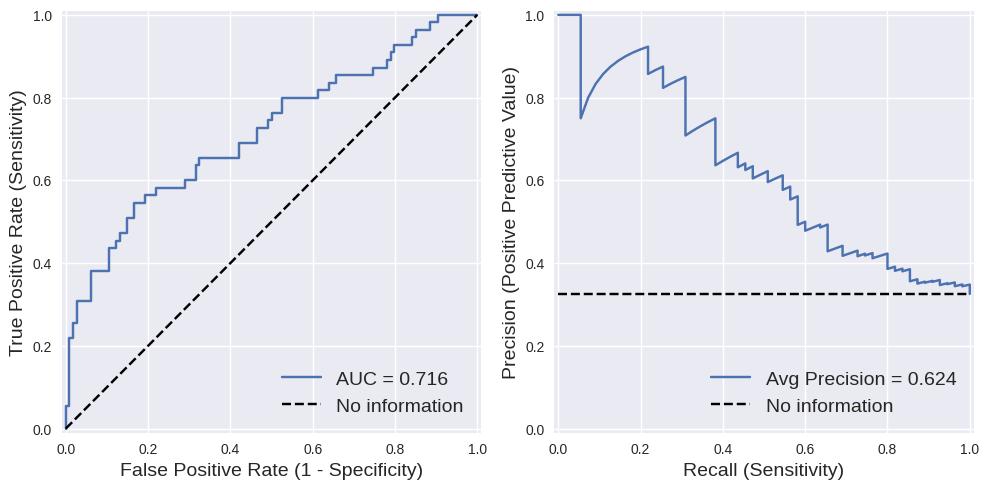

In [ ]:
# Predict on the test data
y_test_pred_proba = lr_model.predict_proba(X_test)[:,1]
y_test_pred_label = (y_test_pred_proba > .5).astype(int) 
# Print accuracy
print_accuracy(y_test, y_test_pred_label)
# Plot ROC and PR curves
plot_roc_and_pr_curves(y_test, y_test_pred_proba)

Since we added random noise, it's not surprising that our results are worse than before. Undoubtedly, our model has identified some spurious relationships between the new, noisy predictors and our outcomes in the training set, but these relationships do not generalize to the test set. Let's look a little more closely by taking a look at what's happening in the training set:

Accuracy = 95.2%


<ipython-input-5-244f5ea96956>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


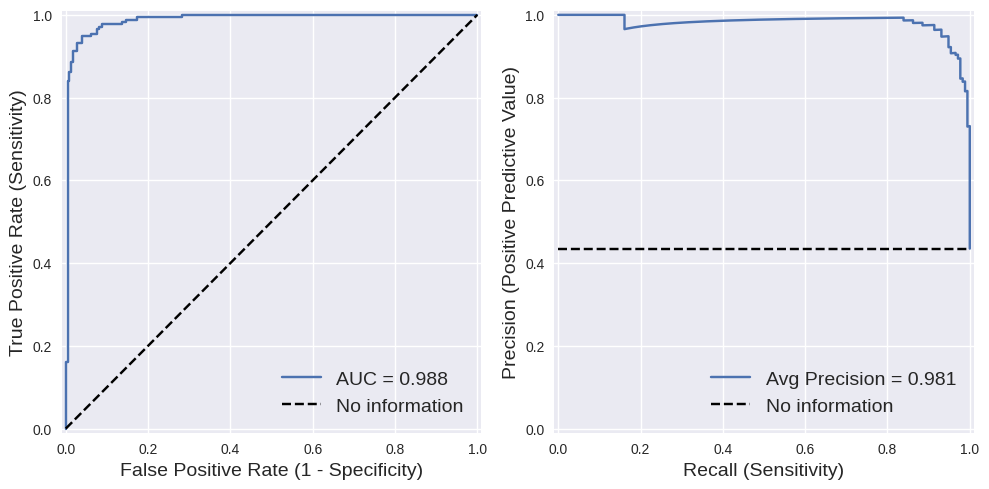

In [ ]:
y_train_pred_proba = lr_model.predict_proba(X_train)[:,1]
y_train_pred_label = (y_train_pred_proba > .5).astype(int)

print_accuracy(y_train, y_train_pred_label)
plot_roc_and_pr_curves(y_train, y_train_pred_proba)

As we guessed, performance is much better on the training set that on the test set. **We are overfitting!**

What can we do about this? As we discussed [in class](https://github.com/mengelhard/bsrt_ml4h/blob/master/lectures/on_n_vs_p.pdf), a common, simple, and effective way to mitigate overfitting is by penalizing large model parameters. This is known as *regularization*.

In fact, regularization is so effective that `sklearn` does it by default for logistic regression; we removed it by specifying `penalty='none'`. Let's instead use an `'l2'` penalty, which means we'll penalize the squared magnitude of each of our coefficients. We can choose how strongly to penalize with the `C` parameter, which we'll set to `.01`.

Accuracy = 86.4%


<ipython-input-5-244f5ea96956>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


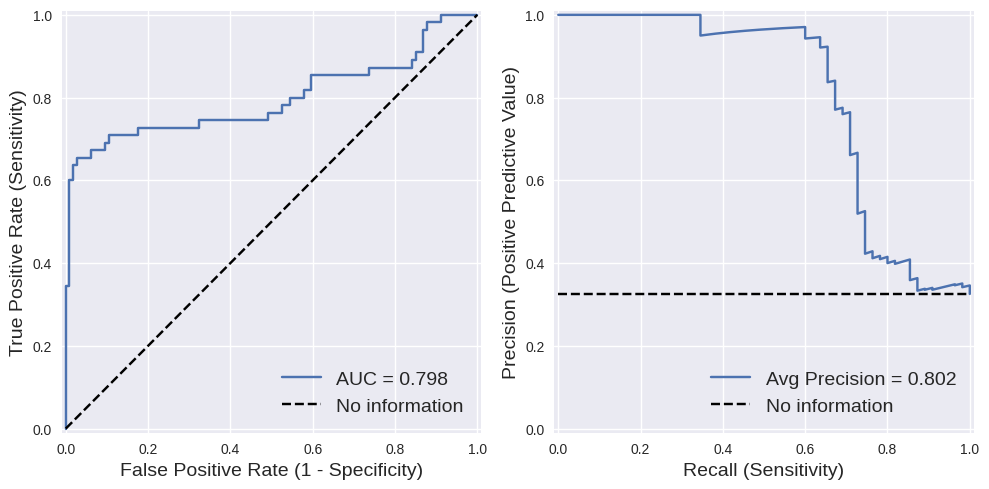

In [ ]:
# Train our logistic regression baseline model

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

reg_lr_model = LogisticRegression(random_state=0, penalty='l2', C=.01, max_iter=10000)
reg_lr_model.fit(X_train, y_train)

y_test_pred_proba = reg_lr_model.predict_proba(X_test)[:,1]
y_test_pred_label = (y_test_pred_proba > .5).astype(int)

print_accuracy(y_test, y_test_pred_label)
plot_roc_and_pr_curves(y_test, y_test_pred_proba)

As we'd hoped, test set performance is now substantially improved, and is now similar to the values you may remember from our earlier exercises. Now, let's turn to the multilayer perceptron and see how all this plays out.

## Multilayer Perceptron

We'll now follow the exact same steps as before, but using a multilayer perceptron with a single, wide hidden layer, which we can specify using `hidden_layer_sizes=(1000,)`. If we instead wanted to use two hidden layers with 100 neurons each, for example, we could use `hidden_layer_sizes=(100, 100)`.

Let's fit this MLP, then take a look at the results. We'll also specify `alpha=0`, which tells the model not to penalize large parameter values (i.e., regularize). This has the same effect as specifying `penalty='none'` in the logistic regression model; the conventions are just a bit different between the two models.

Accuracy = 77.5%


<ipython-input-5-244f5ea96956>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


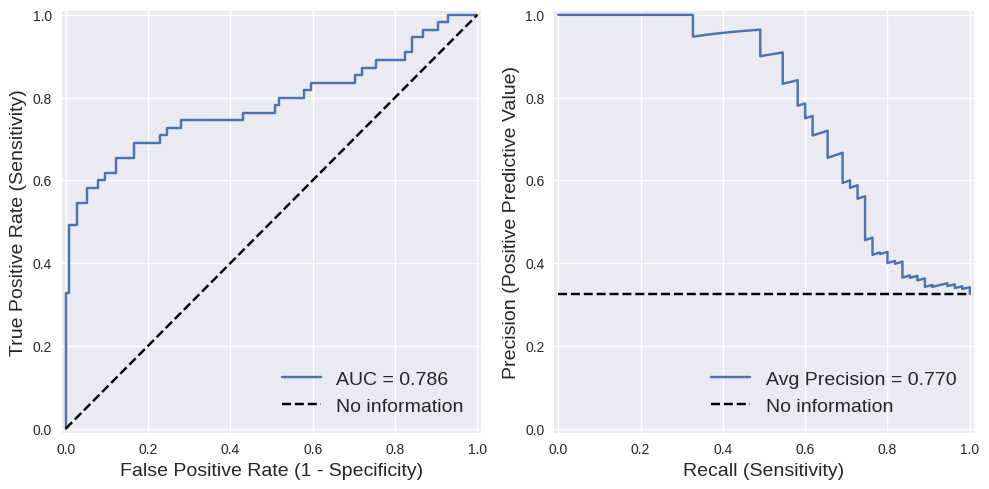

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes=(1000,), random_state=0, max_iter=10000,
                          alpha=0.)
mlp_model.fit(X_train, y_train)

y_test_pred_proba = mlp_model.predict_proba(X_test)[:,1]
y_test_pred_label = (y_test_pred_proba > .5).astype(int)

print_accuracy(y_test, y_test_pred_label)
plot_roc_and_pr_curves(y_test, y_test_pred_proba)

Interestingly, even though we haven't regularized, the MLP does *better* than our original logistic regression model. There are many different perspectives on findings like this, which we can discuss in class. For now, suffice to say that neural networks often perform better in situations like this than we might expect.

If we look at performance on the training set, we'll find that the MLP is *just as overfitted* as the logistic regression model; and yet it generalizes better to the test set.

Accuracy = 100.0%


<ipython-input-5-244f5ea96956>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


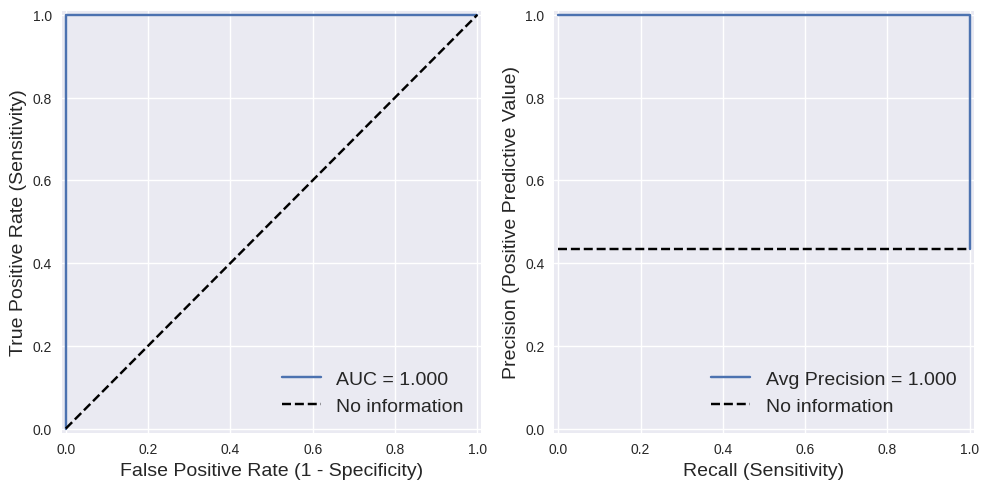

In [ ]:
y_train_pred_proba = mlp_model.predict_proba(X_train)[:,1]
y_train_pred_label = (y_train_pred_proba > .5).astype(int)

print_accuracy(y_train, y_train_pred_label)
plot_roc_and_pr_curves(y_train, y_train_pred_proba)

As expected, the plots above show dramatic overfitting on the training set.

Now, let's explore an approach to mitigate overfitting that is very common when working with neural networks. We'll set `early_stopping=True`. This tells the model to (a) set aside some of the data as a validation set, (b) continuously monitor performance on the validation set during training, and (c) stop training when performance on the validation set stops improving. This is a common and effective method to prevent the model from overfitting, and it also reduces the total training time.

Accuracy = 85.8%


<ipython-input-5-244f5ea96956>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


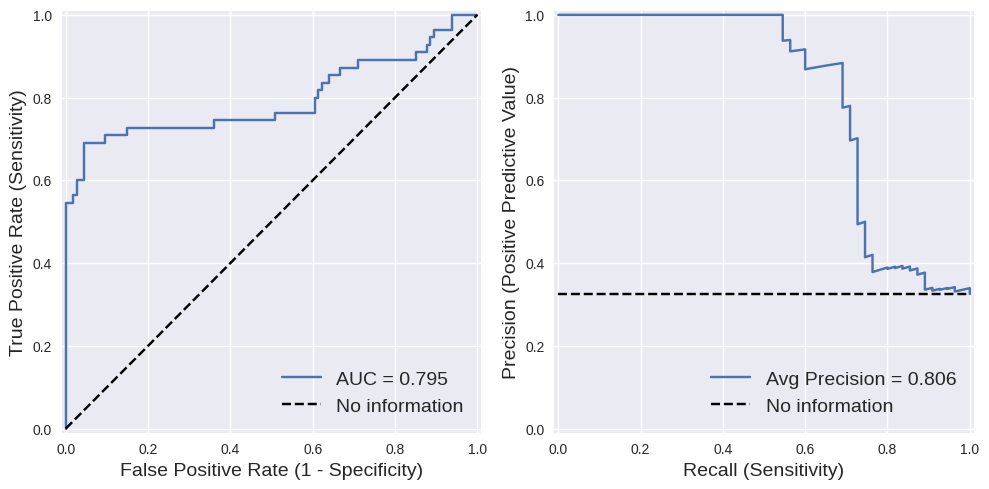

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes=(1000,), random_state=0, max_iter=10000,
                          alpha=0., early_stopping=True)
mlp_model.fit(X_train, y_train)

y_test_pred_proba = mlp_model.predict_proba(X_test)[:,1]
y_test_pred_label = (y_test_pred_proba > .5).astype(int)

print_accuracy(y_test, y_test_pred_label)
plot_roc_and_pr_curves(y_test, y_test_pred_proba)

It was super effective! Accuracy, AUC, and Average Pecision all improved. This strategy is all the more important for very large datasets and very large neural networks.

## Returning to the true labels

It may be interesting to go back to the true data and labels (`df_true` and `y_true`) on your own to see how well logistic regression performs on the original, unmodified prediction task. We modified this problem quite a bit in these exercises to illustrate important concepts related to measuring performance and mitigating overfitting. As it turns out, the unmodified problem can be solved quite well with logistic regression. However, this is *not* the case for computer vision tasks, which we'll be covering over the next few weeks.

## This exercise does not need to be turned in.